In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
import plotly.express as px
import warnings
import os, cv2
import zipfile
import random, gc
from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [34]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# import keras_tuner

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# %cd "/content/drive/My Drive/msba6421_predictive/hw4"

In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  2 21:11:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   9201MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Connect API

In this part, I connected Kaggle API to download and unzip the training and testing data.

In [39]:
# input username and key to connnet to Kaggle API.
os.environ['KAGGLE_USERNAME'] = 'amyqqw'
os.environ['KAGGLE_KEY'] = '41072e48efaae4250588d7c038927185'

# download the competition dataset
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

dogs-vs-cats-redux-kernels-edition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
# unzip file to new directory name "dataset"
with zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [41]:
# list files in the directory
dataset_dir = 'dataset'
contents = os.listdir(dataset_dir)
print(contents)

['train.zip', 'sample_submission.csv', 'test.zip']


In [42]:
%pwd

'/content'

In [43]:
# unzip training dataset
with zipfile.ZipFile('dataset/train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

In [44]:
# unzip testing dataset
with zipfile.ZipFile('dataset/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

In [45]:
gc.collect()

2010

# CNN

## Create Train & Test data

In this part, I read training and testing images data into 256 rows, 256 columns, and 3 channels arrays.

In [46]:
# read all training and testing image paths as lists
seed_value = 42
random.seed(seed_value)

TRAIN_DIR = 'train/train/'
TEST_DIR = 'test/test/'

ROWS = 256
COLS = 256
CHANNELS = 3

train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# Use all training and testing set
train_images = train_dogs + train_cats
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

print(f'Number of training images: {len(train_images)}')
print(f'Number of testing images: {len(test_images)}')

random.shuffle(train_images)

Number of training images: 25000
Number of testing images: 12500


In [47]:
# function for reading and resizing image
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

# function for inserting images into arrays
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))

    return data

X_train = prep_data(train_images)
X_test = prep_data(test_images)

print("Train shape: {}".format(X_train.shape))
print("Test shape: {}".format(X_test.shape))

Processed 0 of 25000
Processed 250 of 25000
Processed 500 of 25000
Processed 750 of 25000
Processed 1000 of 25000
Processed 1250 of 25000
Processed 1500 of 25000
Processed 1750 of 25000
Processed 2000 of 25000
Processed 2250 of 25000
Processed 2500 of 25000
Processed 2750 of 25000
Processed 3000 of 25000
Processed 3250 of 25000
Processed 3500 of 25000
Processed 3750 of 25000
Processed 4000 of 25000
Processed 4250 of 25000
Processed 4500 of 25000
Processed 4750 of 25000
Processed 5000 of 25000
Processed 5250 of 25000
Processed 5500 of 25000
Processed 5750 of 25000
Processed 6000 of 25000
Processed 6250 of 25000
Processed 6500 of 25000
Processed 6750 of 25000
Processed 7000 of 25000
Processed 7250 of 25000
Processed 7500 of 25000
Processed 7750 of 25000
Processed 8000 of 25000
Processed 8250 of 25000
Processed 8500 of 25000
Processed 8750 of 25000
Processed 9000 of 25000
Processed 9250 of 25000
Processed 9500 of 25000
Processed 9750 of 25000
Processed 10000 of 25000
Processed 10250 of 25

In [48]:
# checking training images
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

for idx in range(0,5):
    show_cats_and_dogs(idx)

Output hidden; open in https://colab.research.google.com to view.

In [49]:
# create Y_train array
# dog: 1, cat: 0
Y_train_ = [0 if 'cat' in i else 1 for i in train_images]
Y_train = np.array(Y_train_)
Y_train = to_categorical(Y_train, 2)

In [50]:
Y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

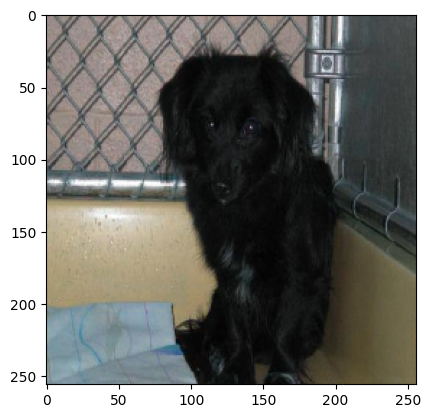

In [51]:
plt.imshow(X_train[2])
plt.show()

## EDA

I examined the distribution of images featuring dogs and cats. It appears to be well-balanced, with an equal number of images for both dogs and cats.

In [52]:
# training data distribution
unique_values, counts = np.unique(np.array(Y_train), return_counts=True)

# Print the value counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} times")

0.0: 25000 times
1.0: 25000 times


## Training

The model comprises two main components: convolution layers and dense layers. In the initial phase, eight convolution layers are employed to capture essential patterns from the input images. MaxPooling layers are incorporated to effectively reduce the number of parameters. To address the issue of vanishing or exploding gradients, batch normalization is applied to every second convolution layer. The activation function used is ReLU, chosen to counteract the problem of gradient vanishing and promote optimal feature learning within the convolutional layers.

Moving on to the second phase, a single dense layer with 512 neurons is introduced, accompanied by batch normalization to enhance training stability. Observing signs of overfitting in the validation and training loss line chart, an early stop mechanism is implemented during the training process. Additionally, to mitigate overfitting, the number of training epochs is reduced to 20.

In [53]:
objective = 'categorical_crossentropy'
nb_pool = 2

def create_model():

    model = Sequential()

    # Convolution layers
    model.add(BatchNormalization())

    model.add(Convolution2D(256, (3, 3), padding='same', input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    # model.add(Convolution2D(256, (1, 1), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    # model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    # model.add(Convolution2D(256, (1, 1), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

    model.add(Flatten())

    # Dense layers
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))

    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))

    model.add(BatchNormalization())
    model.add(Dense(516, activation='relu'))

    model.add(BatchNormalization())
    model.add(Dense(516, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))
    # model.add(Activation('softmax'))
    learning_rate = 1e-4
    model.compile(loss=objective
                  , optimizer=Adam(learning_rate=learning_rate)
                  , metrics=['accuracy'])

    return model

In [54]:
model = create_model()

In [55]:
nb_epoch = 15
batch_size = 30

## Callback for loss logging per epoch
# class LossHistory(Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []
#         self.val_losses = []

#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

def run_catdog():

    # history = LossHistory()
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_split=0.25
              , verbose=0, shuffle=True
              # , callbacks=[history, early_stopping]
              )


    predictions = model.predict(X_test, verbose=0)
    return predictions

In [56]:
gc.collect()

9873

In [57]:
# training and predicting
pred = run_catdog()

In [63]:
# Output submission file
lst = [i[1] for i in pred]
test_id = [i.split('test/test/')[1][:-4] for i in test_images]
submission = pd.DataFrame({'id':test_id, 'label':lst})
submission.to_csv('drive/MyDrive/msba6421_predictive/hw4/1130_submission_8.csv', index=False)

In [64]:
submission

,id,label
0,11246,0.073572
1,5797,0.012891
2,9495,0.968131
3,9846,0.009290
4,3016,1.000000
...,...,...
12495,6739,0.403861
12496,9821,0.950555
12497,7820,0.999993
12498,5459,0.999983


# Pretrained ResNet101

I utilized the pre-trained ResNet101 model from Keras for prediction. The training process involved using 80% of the data from the training dataset for training the model, while the remaining 20% served as the validation dataset. To accommodate the model's limitations, I assumed uniform dimensions for each image, resizing them all to a 160x160x3 array.

The model was structured with three main components: the ResNet, a pooling layer, and an output layer. The ResNet101 layer was initialized with hyperparameters 'weights=imagenet,' indicating the use of pre-trained weights from the ImageNet dataset. Additionally, the hyperparameter 'include_top' was set to False, allowing for the addition of a custom output layer later on. To optimize computational efficiency, I did not add any larger Dense layer. I opted for GlobalAveragePooling2D() instead of Flatten() after the ResNet layer since Global pooling consolidates all feature maps into a single map, simplifying the information for a subsequent dense classification layer. Finally, the output layer was configured as a Dense layer with a single neuron, employing the 'sigmoid' activation function.

The training configuration included setting the number of epochs to 10 and the batch size to 128 to prevent overfitting during the training process.

The final score is 0.11526

## Create Train & Test data

In [16]:
# read all training and testing image paths as lists
seed_value = 42
random.seed(seed_value)

TRAIN_DIR = 'train/train/'
TEST_DIR = 'test/test/'

ROWS = 160
COLS = 160
CHANNELS = 3

train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# Use all training and testing set
all_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

limit = int( 0.8* len(all_images))

train_images = all_images[0:limit]
validation_images = all_images[limit:]

print(f'Number of training images: {len(train_images)}')
print(f'Number of validation images: {len(validation_images)}')
print(f'Number of testing images: {len(test_images)}')

random.shuffle(train_images)

Number of training images: 20000
Number of validation images: 5000
Number of testing images: 12500


In [17]:
def getallimages(path):
    actualdata = np.ndarray((len(path),ROWS,COLS,3),dtype=np.uint8)
    for index , file in enumerate(path):
        img = cv2.imread(file)
        img= cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
#         img = tf.cast(img,tf.float32)
#         img = (img/127.5) - 1
#         img = tf.image.resize(img, (rows, columns))
        actualdata[index] = img
    return actualdata

train = getallimages(train_images)
test = getallimages(test_images)
validation = getallimages(validation_images)

In [18]:
train.shape
test.shape
validation.shape

(5000, 160, 160, 3)

In [19]:
label = [1 if 'dog' in i else 0 for i in train_images]
validation_label = [1 if 'dog' in i else 0 for i in validation_images]

## Model Building

In [20]:
image_shape = (ROWS,COLS,3)

base_model = tf.keras.applications.ResNet101(
    weights = 'imagenet', include_top=False, input_shape=image_shape)
base_model.trainable=False
# base_model.summary()

171446536/171446536 [==============================] - 5s 0us/step


In [22]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
base_learning_rate = 0.001
# you can use this tootf.keras.optimizers.RMSprop(learning_rate=base_learning_rate
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 42660225 (162.74 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


## Training

In [23]:
epochs = 10
validation_steps=20

model.fit(x=np.array(train),
          y=np.array(label),
          validation_data=(np.array(validation),
                           np.array(validation_label)) ,
          batch_size=128,
          epochs=epochs,shuffle=True)

Epoch 1/10
157/157 [==============================] - 82s 427ms/step - loss: 0.1279 - accuracy: 0.9470 - val_loss: 0.0713 - val_accuracy: 0.9726
Epoch 2/10
157/157 [==============================] - 63s 400ms/step - loss: 0.0635 - accuracy: 0.9758 - val_loss: 0.0673 - val_accuracy: 0.9732
Epoch 3/10
157/157 [==============================] - 63s 399ms/step - loss: 0.0546 - accuracy: 0.9791 - val_loss: 0.0614 - val_accuracy: 0.9772
Epoch 4/10
157/157 [==============================] - 63s 399ms/step - loss: 0.0497 - accuracy: 0.9814 - val_loss: 0.0617 - val_accuracy: 0.9780
Epoch 5/10
157/157 [==============================] - 63s 399ms/step - loss: 0.0467 - accuracy: 0.9829 - val_loss: 0.0633 - val_accuracy: 0.9758
Epoch 6/10
157/157 [==============================] - 63s 400ms/step - loss: 0.0451 - accuracy: 0.9832 - val_loss: 0.0615 - val_accuracy: 0.9776
Epoch 7/10
157/157 [==============================] - 63s 399ms/step - loss: 0.0407 - accuracy: 0.9857 - val_loss: 0.0792 - val_ac

## Predicting

In [26]:
prediction  = model.predict(test,verbose=1)


391/391 [==============================] - 39s 95ms/step


,id,label
0,,2.229323e-01
1,,4.682397e-05
2,,9.989607e-01
3,,1.583955e-07
4,,9.999998e-01
...,...,...
12495,,1.933952e-06
12496,,9.996802e-01
12497,,9.999671e-01
12498,,5.773515e-01


In [59]:
test_id = [i.split('test/test/')[1][:-4] for i in test_images]
predictions_df = pd.DataFrame({'id': test_id, 'label': prediction[:,0]})
predictions_df
predictions_df.to_csv('drive/MyDrive/msba6421_predictive/hw4/Session2.Amy Chiu.csv', index=False)

In [32]:
predictions_df

,id,label
0,11246,2.229323e-01
1,5797,4.682397e-05
2,9495,9.989607e-01
3,9846,1.583955e-07
4,3016,9.999998e-01
...,...,...
12495,6739,1.933952e-06
12496,9821,9.996802e-01
12497,7820,9.999671e-01
12498,5459,5.773515e-01


In [27]:
prediction

array([[2.2293234e-01],
       [4.6823967e-05],
       [9.9896073e-01],
       ...,
       [9.9996710e-01],
       [5.7735145e-01],
       [6.9023331e-06]], dtype=float32)